## Objective
The goal of this project is to build a machine learning model that can classify news
articles as fake or real using Natural Language Processing techniques.

Labels:
- 0 → Fake news
- 1 → Real news


Let's prepare the enviroment and import the dataset.

In [42]:
import pandas as pd
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv(r"C:\Users\tlili\OneDrive\Bureau\Bootcamp\labs\project-3-nlp\dataset\training_data.csv",encoding='latin-1')


## Explore the data 

In [29]:
data.head()

,ï»¿0\tdonald trump sends out embarrassing new yearâs eve message; this is disturbing
0,0\tdrunk bragging trump staffer started russia...
1,0\tsheriff david clarke becomes an internet jo...
2,0\ttrump is so obsessed he even has obamaâs ...
3,0\tpope francis just called out donald trump d...
4,0\tracist alabama cops brutalize black boy whi...


In [30]:
data.shape

(34151, 1)

* the label and text are mixed together in a single column we need to separate them , let's load the data set again with a seperation of columns

In [31]:
df = pd.read_csv(
    r"C:\Users\tlili\OneDrive\Bureau\Bootcamp\labs\project-3-nlp\dataset\training_data.csv",
    sep="\t",
    encoding="latin-1",
    header=None
)

df.head()

,0,1
0,ï»¿0,donald trump sends out embarrassing new yearâ...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obamaâs nam...
4,0,pope francis just called out donald trump duri...


In [34]:
df.columns = ["label", "text"]
df.head(20)

,label,text
0,ï»¿0,donald trump sends out embarrassing new yearâ...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obamaâs nam...
4,0,pope francis just called out donald trump duri...
5,0,racist alabama cops brutalize black boy while ...
6,0,fresh off the golf course
7,0,trump said some insanely racist stuff inside t...
8,0,former cia director slams trump over un bullying
9,0,brand-new pro-trump ad features so much a** ki...


In [23]:
df.shape

(34152, 2)

In [24]:
df.isnull().sum()

label    0
text     0
dtype: int64

## Preprocessing the data 

* we noticed "ï»¿0" in the label column and "â" in the text column, which are likely encoding issues. Let's clean these up.

In [35]:
import re
df["label"] = df["label"].astype(str).str.replace("ï»¿", "", regex=False)
df["label"] = df["label"].astype(int)

df["label"].value_counts()

label
0    17572
1    16580
Name: count, dtype: int64

In [36]:
def fix_text_encoding(text):
    if isinstance(text, str):
        return (
            text.encode("latin1", errors="ignore")
                .decode("utf-8", errors="ignore")
        )
    return text

df["text"] = df["text"].apply(fix_text_encoding)


In [37]:
df.head()

,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


* Define the stopwords

In [38]:
import nltk
from nltk.corpus import stopwords

In [39]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tlili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))

# see some stopwords
list(stop_words)[:20]


["i'll",
 "mustn't",
 'doesn',
 'y',
 "they'd",
 'too',
 'for',
 'how',
 've',
 'as',
 'they',
 "doesn't",
 'i',
 "it'd",
 "mightn't",
 'am',
 'couldn',
 'you',
 'yourself',
 'such']

* lowercase  
* Remove : punctuation , numbers ,stopwords and extra spaces

In [43]:
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # 3. Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # 4. Remove numbers
    text = re.sub(r"\d+", "", text)
    
    # 5. Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # 6. Rejoin words
    text = " ".join(words)
    
    return text


In [44]:
df["clean_text"] = df["text"].apply(preprocess_text)

df[["text", "clean_text"]].head()

,text,clean_text
0,donald trump sends out embarrassing new year‚s...,donald trump sends embarrassing new year‚s eve...
1,drunk bragging trump staffer started russian c...,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes an internet joke ...,sheriff david clarke becomes internet joke thr...
3,trump is so obsessed he even has obama‚s name ...,trump obsessed even obama‚s name coded website...
4,pope francis just called out donald trump duri...,pope francis called donald trump christmas speech


## Split the data

In [46]:
from sklearn.model_selection import train_test_split

# First, split into train + temp (validation + test)
X = df["clean_text"]
y = df["label"]

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Now split temp into validation and test (15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print sizes
print("Training set:", X_train.shape[0])
print("Validation set:", X_val.shape[0])
print("Test set:", X_test.shape[0])


Training set: 23906
Validation set: 5123
Test set: 5123


## Vectorization IF - IDF 

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  
    ngram_range=(1, 1), 
    stop_words=None     
)

# Fit on training data and transform
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform validation and test data
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check shape
print("Training feature matrix shape:", X_train_tfidf.shape)
print("Validation feature matrix shape:", X_val_tfidf.shape)
print("Test feature matrix shape:", X_test_tfidf.shape)


Training feature matrix shape: (23906, 5000)
Validation feature matrix shape: (5123, 5000)
Test feature matrix shape: (5123, 5000)


## Train logistic regression model  

* Trial 1 : Baseline Model with default TF-IDF parameters

Test Accuracy: 0.9320710521178996

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      2636
           1       0.92      0.94      0.93      2487

    accuracy                           0.93      5123
   macro avg       0.93      0.93      0.93      5123
weighted avg       0.93      0.93      0.93      5123



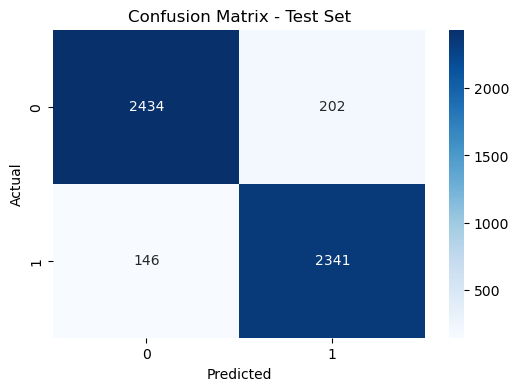

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train on TF-IDF features
lr_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_test_pred = lr_model.predict(X_test_tfidf)

# Evaluate performance
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()


* Trial 2 : try ngrams (1,2) instead of unigrams (1,1) only

In [49]:
# Create TF-IDF vectorizer
tfidf_vectorizer2 = TfidfVectorizer(
    max_features=5000,  
    ngram_range=(1, 2), 
    stop_words=None     
)

# Fit on training data and transform
X_train_tfidf2 = tfidf_vectorizer2.fit_transform(X_train)

# Transform validation and test data
X_val_tfidf2 = tfidf_vectorizer2.transform(X_val)
X_test_tfidf2 = tfidf_vectorizer2.transform(X_test)
# Check shape
print("Training feature matrix shape:", X_train_tfidf2.shape)
print("Validation feature matrix shape:", X_val_tfidf2.shape)
print("Test feature matrix shape:", X_test_tfidf2.shape)

Training feature matrix shape: (23906, 5000)
Validation feature matrix shape: (5123, 5000)
Test feature matrix shape: (5123, 5000)


Test Accuracy (Trial 2): 0.9342182315049775

Classification Report (Trial 2):
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      2636
           1       0.92      0.94      0.93      2487

    accuracy                           0.93      5123
   macro avg       0.93      0.93      0.93      5123
weighted avg       0.93      0.93      0.93      5123



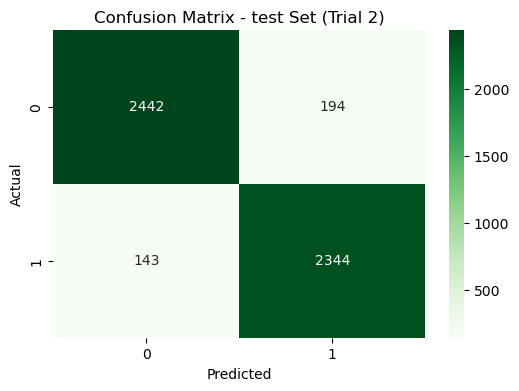

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression model for second trial
lr_model2 = LogisticRegression(max_iter=1000, random_state=42)

# Train on TF-IDF n-grams features
lr_model2.fit(X_train_tfidf2, y_train)

# Predict on test set
y_test_pred2 = lr_model2.predict(X_test_tfidf2)

# Evaluate performance
print("Test Accuracy (Trial 2):", accuracy_score(y_test, y_test_pred2))
print("\nClassification Report (Trial 2):\n", classification_report(y_test, y_test_pred2))

# Confusion matrix
cm2 = confusion_matrix(y_test, y_test_pred2)
plt.figure(figsize=(6,4))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - test Set (Trial 2)")
plt.show()


* insights : 
Capturing phrases matters:Some news patterns like "breaking news", "fact check" are strong indicators of fake/real news.

* Trial 3 :Tune TF-IDF parameters:

In [51]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer with tuned parameters
tfidf_vectorizer3 = TfidfVectorizer(
    max_features=10000,      # more features
    ngram_range=(1, 2),      # unigrams + bigrams
    min_df=5,                # ignore very rare words
    max_df=0.8,              # ignore very common words
    stop_words=None           # stopwords already removed
)

# Fit on training data and transform
X_train_tfidf3 = tfidf_vectorizer3.fit_transform(X_train)

# Transform validation and test sets
X_val_tfidf3 = tfidf_vectorizer3.transform(X_val)
X_test_tfidf3 = tfidf_vectorizer3.transform(X_test)

# Check shapes
print("Training feature matrix shape:", X_train_tfidf3.shape)
print("Validation feature matrix shape:", X_val_tfidf3.shape)
print("Test feature matrix shape:", X_test_tfidf3.shape)


Training feature matrix shape: (23906, 8817)
Validation feature matrix shape: (5123, 8817)
Test feature matrix shape: (5123, 8817)


Test Accuracy (Trial 3): 0.9367558071442514

Classification Report (Test Set - Trial 3):
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      2636
           1       0.93      0.94      0.94      2487

    accuracy                           0.94      5123
   macro avg       0.94      0.94      0.94      5123
weighted avg       0.94      0.94      0.94      5123



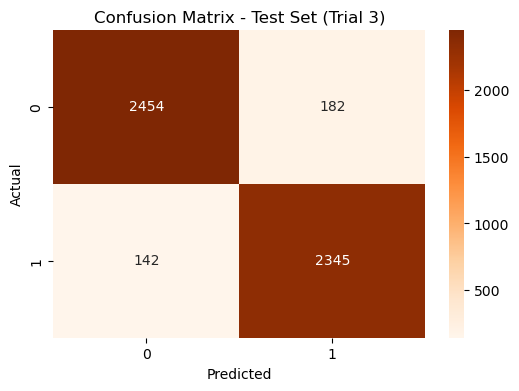

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression model for third trial
lr_model3 = LogisticRegression(max_iter=1000, random_state=42)

# Train on TF-IDF tuned features
lr_model3.fit(X_train_tfidf3, y_train)

# Predict on test set
y_test_pred3 = lr_model3.predict(X_test_tfidf3)


# Evaluate performance

print("Test Accuracy (Trial 3):", accuracy_score(y_test, y_test_pred3))
print("\nClassification Report (Test Set - Trial 3):\n",
      classification_report(y_test, y_test_pred3))

# Confusion matrix
cm3 = confusion_matrix(y_test, y_test_pred3)
plt.figure(figsize=(6,4))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Oranges", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set (Trial 3)")
plt.show()


* insights : Increasing max_features allows the model to consider more words

min_df and max_df remove noise → better signal-to-noise ratio

* At this stage we reached the best accuracy we can get using the logistic regression model with TF-IDF features , in the next trial we will try the linear SVM model keeping the same parameters of the Third trial 

## Linear SVM ( support vector machine ) Model 

* Trial 5 : Linear SVM with same TF-IDF parameters as Trial 3

Test Accuracy (Linear SVM): 0.9414405621706031

Classification Report (Linear SVM):
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      2636
           1       0.94      0.94      0.94      2487

    accuracy                           0.94      5123
   macro avg       0.94      0.94      0.94      5123
weighted avg       0.94      0.94      0.94      5123



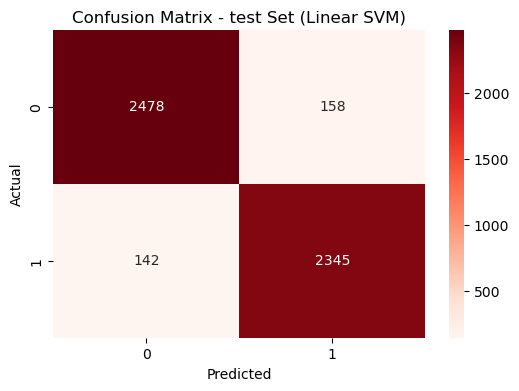

In [80]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Linear SVM model
svm_model = LinearSVC(random_state=42)

# Train on TF-IDF features from Trial 3
svm_model.fit(X_train_tfidf3, y_train)

# Predict on test set
y_test_pred_svm = svm_model.predict(X_test_tfidf3)

# Evaluation
print("Test Accuracy (Linear SVM):",
      accuracy_score(y_test, y_test_pred_svm))
print("\nClassification Report (Linear SVM):\n",
      classification_report(y_test, y_test_pred_svm))

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_test_pred_svm)

plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Reds",
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - test Set (Linear SVM)")
plt.show()


* The linear SVM outperforms Logistic regression because it finds the optimal classification boundary by maximizing the margin between classes leading to a better generalization on unseen data 
compared to logistic regression which estimates probabilities and may draw multiplue decision boundaries.

in the bellow image there are multiple decision boundaries that will do the job of classification accurately but the filled one is better than the dashed one since it divides the points optimally  leaving enough room for potential outliers.

An SVM tries to draw this optimum decision boundary while logistic regression might draw any one of those boundaries which my cause classification errors for outliers.


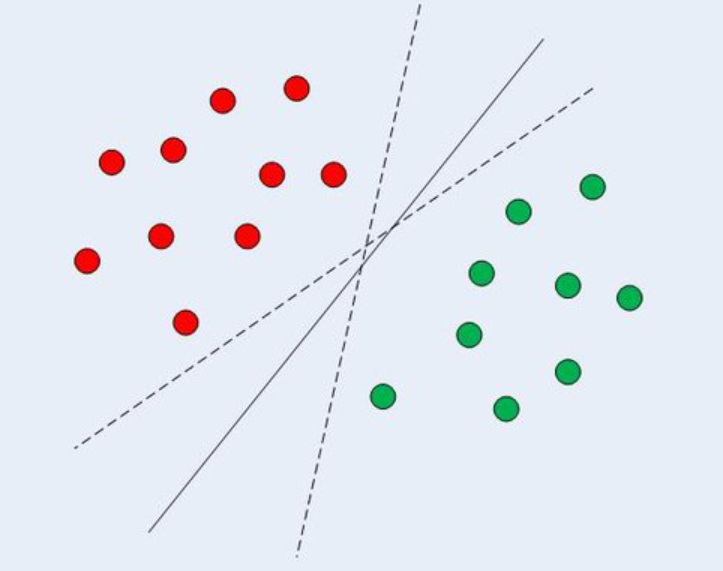

* Trial 6 : Hyperparameter tuning for Linear SVM 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorizer with tuned parameters
tfidf_vectorizer6 = TfidfVectorizer(
    max_features=15000,      # include more words
    ngram_range=(1,3),       # unigrams + bigrams + trigrams
    min_df=5,                # ignore very rare words
    max_df=0.8,              # ignore very common words
    stop_words=None           # already removed in preprocessing
)

# Fit & transform training data
X_train_tfidf6 = tfidf_vectorizer6.fit_transform(X_train)

# Transform validation and test sets
X_val_tfidf6 = tfidf_vectorizer6.transform(X_val)
X_test_tfidf6 = tfidf_vectorizer6.transform(X_test)

# Check shapes
print("Training feature matrix shape:", X_train_tfidf6.shape)
print("Validation feature matrix shape:", X_val_tfidf6.shape)
print("Test feature matrix shape:", X_test_tfidf6.shape)


Training feature matrix shape: (23906, 9213)
Validation feature matrix shape: (5123, 9213)
Test feature matrix shape: (5123, 9213)


Test Accuracy ( Linear SVM + Trigrams): 0.9414405621706031

Classification Report ( Test Set):
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      2636
           1       0.94      0.94      0.94      2487

    accuracy                           0.94      5123
   macro avg       0.94      0.94      0.94      5123
weighted avg       0.94      0.94      0.94      5123



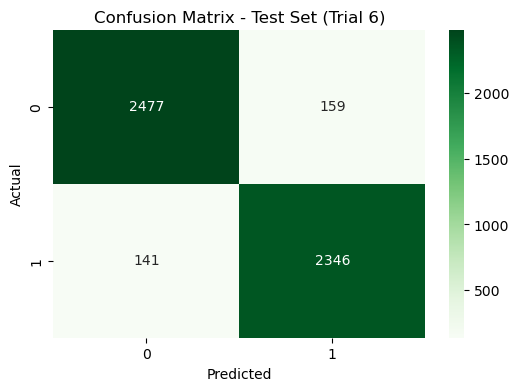

In [81]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create Linear SVM model
lr_svm6 = LinearSVC(random_state=42)

# Train on the new TF-IDF features
lr_svm6.fit(X_train_tfidf6, y_train)

# Predict on test set
y_test_pred6 = lr_svm6.predict(X_test_tfidf6)

# Evaluate test performance
print("Test Accuracy ( Linear SVM + Trigrams):", accuracy_score(y_test, y_test_pred6))
print("\nClassification Report ( Test Set):\n", classification_report(y_test, y_test_pred6))

# Confusion matrix
cm6 = confusion_matrix(y_test, y_test_pred6)
plt.figure(figsize=(6,4))
sns.heatmap(cm6, annot=True, fmt="d", cmap="Greens",
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set (Trial 6)")
plt.show()


## SGD classifier Model  

* Trial 7: use sgd classifier with same if_idf parameters as trial 3

Test Accuracy (Trial 7 - SGDClassifier): 0.9392933827835253

Classification Report (Trial 7 - Test Set):
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      2636
           1       0.93      0.95      0.94      2487

    accuracy                           0.94      5123
   macro avg       0.94      0.94      0.94      5123
weighted avg       0.94      0.94      0.94      5123



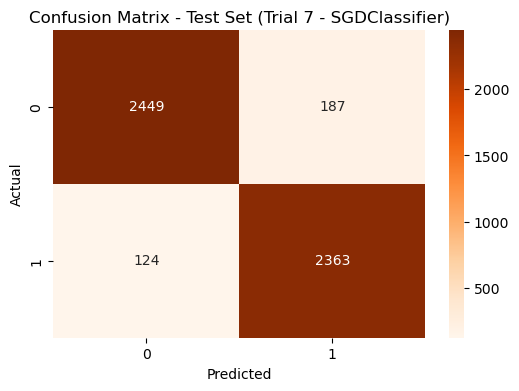

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# SGDClassifier 
sgd_model7 = SGDClassifier(
    loss='hinge',     
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

# Train on TF-IDF features from Trial 3
sgd_model7.fit(X_train_tfidf3, y_train)

# Predict on test set
y_test_pred7 = sgd_model7.predict(X_test_tfidf3)

# Evaluation
print("Test Accuracy (Trial 7 - SGDClassifier):", accuracy_score(y_test, y_test_pred7))
print("\nClassification Report (Trial 7 - Test Set):\n", classification_report(y_test, y_test_pred7))

# Confusion matrix
cm7 = confusion_matrix(y_test, y_test_pred7)
plt.figure(figsize=(6,4))
sns.heatmap(cm7, annot=True, fmt="d", cmap="Oranges",
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set (Trial 7 - SGDClassifier)")
plt.show()


## XGBOOST Model

Test Accuracy (Trial 8 - XGBoost): 0.9098184657427288

Classification Report (Trial 8 - XGBoost):
               precision    recall  f1-score   support

           0       0.94      0.89      0.91      2636
           1       0.88      0.94      0.91      2487

    accuracy                           0.91      5123
   macro avg       0.91      0.91      0.91      5123
weighted avg       0.91      0.91      0.91      5123



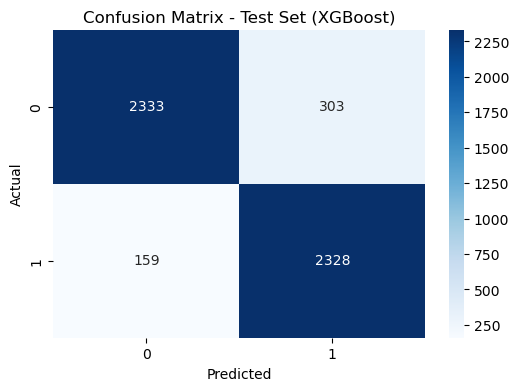

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Train model
xgb_model.fit(X_train_tfidf3, y_train)

# Predict on test set
y_test_pred_xgb = xgb_model.predict(X_test_tfidf3)

# Evaluation
print("Test Accuracy (Trial 8 - XGBoost):",
      accuracy_score(y_test, y_test_pred_xgb))

print("\nClassification Report (Trial 8 - XGBoost):\n",
      classification_report(y_test, y_test_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set (XGBoost)")
plt.show()


# Conclusion : 

* our best model so far is the linear SVM from trial 5 with an accuracy of 94,14% on the validation and test, let's save it and then use it to predict the data in our file testing_data.csv

In [71]:
import joblib

# Save the trained SVM model
joblib.dump(svm_model, "linear_svm_trial5.pkl")

# Save the TF-IDF vectorizer used in Trial 3
joblib.dump(tfidf_vectorizer3, "tfidf_vectorizer3.pkl")

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!


In [79]:
import pandas as pd
import joblib

# Load the saved model and TF-IDF vectorizer
svm_model_loaded = joblib.load("linear_svm_trial5.pkl")
tfidf_vectorizer_loaded = joblib.load("tfidf_vectorizer3.pkl")

# Load the new dataset
testing_df = pd.read_csv(
    r"C:\Users\tlili\OneDrive\Bureau\Bootcamp\labs\project-3-nlp\dataset\testing_data.csv",
    sep="\t", encoding="utf-8", header=None, names=["label", "text"]
)

# Fix encoding if needed
def fix_encoding(text):
    if isinstance(text, str):
        return text.encode("latin1", errors="ignore").decode("utf-8", errors="ignore")
    return text

testing_df["text"] = testing_df["text"].apply(fix_encoding)

# Transform text to TF-IDF
X_testing_tfidf = tfidf_vectorizer_loaded.transform(testing_df["text"])

# Predict labels
predicted_labels = svm_model_loaded.predict(X_testing_tfidf)

# Replace the placeholder labels (2) with predictions
testing_df["label"] = predicted_labels

# Save the predictions back to CSV
testing_df.to_csv("testing_data_predicted.csv", index=False, sep="\t")

print("Predictions added successfully! First 10 rows:")
print(testing_df.head(10))


Predictions added successfully! First 10 rows:
   label                                               text
0      0  copycat muslim terrorist arrested with assault...
1      0  wow! chicago protester caught on camera admits...
2      0   germany's fdp look to fill schaeuble's big shoes
3      0  mi school sends welcome back packet warning ki...
4      1  u.n. seeks 'massive' aid boost amid rohingya '...
5      0  did oprah just leave nasty hillary wishing she...
6      1  france's macron says his job not 'cool' cites ...
7      0  flashback: chilling 60 minutes interview with ...
8      1  spanish foreign ministry says to expel north k...
9      1  trump says cuba 'did some bad things' aimed at...
